In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import PyQt5
import os
from matplotlib import pyplot as plt


In [2]:
def list_files_in_dir(path):
    file_list = []
    for fname in os.listdir(path):
        newpath = os.path.join(path, fname)
        if os.path.isdir(newpath):
            # skip directories
            continue
        file_list.append(fname)
    # file_list.sort(key=lambda f: int("".join(filter(str.isdigit, f))))
    return file_list

In [3]:
plt.close('all')
column_names=["Left Angle","Right Angle"]
# a = andt.AngleDetector
path = "../data/exp/"
files = list_files_in_dir(path)

print(files)
dataframes = []
for file in files:
    full_path = path + file
    print(str(full_path))
    curr_df = pd.read_csv(full_path, names=column_names) 
    dataframes.append(curr_df)

['agk2010_full_06_23_exp1.csv', 'agk2010_full_06_23_exp3.csv', 'agk2010_full_06_23_exp5.csv', 'agk2010_full_06_23_exp6.csv', 'agk2010_full_06_23_exp7.csv', 'agk2010_sifted1mm_06_23_exp1.csv', 'agk2010_sifted1mm_06_23_exp2.csv', 'agk2010_sifted1mm_06_23_exp3.csv', 'agk2010_sifted1mm_06_23_exp4.csv', 'agk2010_sifted1mm_06_23_exp5.csv']
../data/exp/agk2010_full_06_23_exp1.csv
../data/exp/agk2010_full_06_23_exp3.csv
../data/exp/agk2010_full_06_23_exp5.csv
../data/exp/agk2010_full_06_23_exp6.csv
../data/exp/agk2010_full_06_23_exp7.csv
../data/exp/agk2010_sifted1mm_06_23_exp1.csv
../data/exp/agk2010_sifted1mm_06_23_exp2.csv
../data/exp/agk2010_sifted1mm_06_23_exp3.csv
../data/exp/agk2010_sifted1mm_06_23_exp4.csv
../data/exp/agk2010_sifted1mm_06_23_exp5.csv


In [4]:
import numpy as np

vid_fps = 60
dt = 1/vid_fps

for i, df in enumerate(dataframes):
    time = np.arange(0, df.shape[0] * dt, dt)
    df['Time'] = time
    df['Experiment'] = files[i]
    df[column_names[0]] = df[column_names[0]] * -1
    df["Mean"] = (df['Left Angle'] + df['Right Angle']) / 2

In [5]:
dataframes[0].head()

,Left Angle,Right Angle,Time,Experiment,Mean
0,-0.0,0.0,0.000000,agk2010_full_06_23_exp1.csv,0.0
1,-0.0,0.0,0.016667,agk2010_full_06_23_exp1.csv,0.0
2,-0.0,0.0,0.033333,agk2010_full_06_23_exp1.csv,0.0
3,-0.0,0.0,0.050000,agk2010_full_06_23_exp1.csv,0.0
4,-0.0,0.0,0.066667,agk2010_full_06_23_exp1.csv,0.0


In [6]:
df = pd.concat(dataframes,)

In [7]:
df_filtered = df
win = 10 

df_filtered["Filtered Mean"] = df_filtered["Mean"].rolling(win).mean()
df_filtered["Filtered Mean"] = df_filtered["Filtered Mean"].fillna(0)

df_filtered["Filtered Left"] = df_filtered["Left Angle"].rolling(win).mean()
df_filtered["Filtered Left"] = df_filtered["Filtered Left"].fillna(0)

df_filtered["Filtered Right"] = df_filtered["Right Angle"].rolling(win).mean()
df_filtered["Filtered Right"] = df_filtered["Filtered Right"].fillna(0)
df_filtered.tail()

,Left Angle,Right Angle,Time,Experiment,Mean,Filtered Mean,Filtered Left,Filtered Right
4033,43.062615,45.457925,67.216667,agk2010_sifted1mm_06_23_exp5.csv,44.260270,44.735241,43.922117,45.548366
4034,43.986549,45.591211,67.233333,agk2010_sifted1mm_06_23_exp5.csv,44.788880,44.708854,43.879959,45.537748
4035,44.348266,45.431192,67.250000,agk2010_sifted1mm_06_23_exp5.csv,44.889729,44.686584,43.862039,45.511129
4036,44.198090,45.270261,67.266667,agk2010_sifted1mm_06_23_exp5.csv,44.734175,44.672588,43.874109,45.471067
4037,44.882591,45.350841,67.283333,agk2010_sifted1mm_06_23_exp5.csv,45.116716,44.678815,43.918567,45.439063


In [8]:
def find_index_range(df, column, threshold):
    # Create a new column 'below_threshold' that is True when 'angle' is below the threshold and False otherwise
    df['below_threshold'] = df[column] < threshold

    # Compute differences in 'below_threshold' to find where it changes
    df['below_threshold_diff'] = df['below_threshold'].astype(int).diff()

    # Identify the start and end of each range
    starts = df[df['below_threshold_diff'] == 1].index
    ends = df[df['below_threshold_diff'] == -1].index

    # If the first range starts from the first row, add 0 at the beginning of ends
    if starts[0] == 0:
        ends = np.r_[0, ends]

    # If the last range goes to the last row, add the index of the last row to ends
    if starts[-1] > ends[-1]:
        ends = np.r_[ends, df.index[-1]]

    # Compute lengths of the ranges
    lengths = ends - starts

    # Get the index of the longest range
    max_range_idx = lengths.argmax()

    # Get the start and end index of the longest range
    start_idx, end_idx = starts[max_range_idx], ends[max_range_idx]

    print(f'The longest range where the angle is less than {threshold} is from {start_idx} to {end_idx}.')
    return start_idx, end_idx

def calculate_stats(s):
    stats = {
        'cummax': [s.cummax().iloc[-1]],  # taking the last value as it's a cumulative statistic
        'cummin': [s.cummin().iloc[-1]],  # taking the last value as it's a cumulative statistic
        'median': [s.median()],
        'mean': [s.mean()],
        'std': [s.std()],
        'var': [s.var()],
        'skew': [s.skew()],
        'kurt': [s.kurt()],
    }
    return stats


In [9]:
from statsmodels.tsa.stattools import adfuller
# df_filtered["Tilt"] = df_filtered["Filtered Left"] - df_filtered["Filtered Right"]
average = {}
stats = {}
new_df = pd.DataFrame()
i = 0
for value, group_df in df_filtered.groupby('Experiment'):
    
    print(f'|#####################################|')
    # group_df['Right Angle Derivative'].min
    group_df['Right Angle Derivative'] = group_df['Filtered Right'].diff()
    group_df['Left Angle Derivative'] = group_df['Filtered Left'].diff()
    group_df['Right Angle Derivative2'] = group_df['Right Angle Derivative'].diff()
    group_df['Left Angle Derivative2'] = group_df['Left Angle Derivative'].diff()
    group_df['R_Der'] = group_df["Left Angle Derivative"].rolling(7).std()   
    group_df['Column_Integral'] = group_df['R_Der'].rolling(10).std()
    group_df['Tilt'] = group_df['Filtered Left'] - group_df['Filtered Right']
    start_idx, end_idx = find_index_range(group_df, 'R_Der', 0.4)
    
    cropped_df = group_df.loc[start_idx:end_idx].copy()
    
    # reversed_series = group_df['R_Der'][::-1]
    # stable_index_reversed = (reversed_series.abs() >= 2.5).idxmax()
    # stable_index = group_df.shape[0] - stable_index_reversed - 1
    # print(f'Stable index: {stable_index}/{group_df.shape[0]}')
    perc = cropped_df['Filtered Left'].shape[0] / group_df['Filtered Left'].shape[0] * 100
    print(f"Used range: {perc:.2f}% of experiment")
    result = adfuller(group_df['Filtered Left'], None, 'c')
    result_crop = adfuller(cropped_df['Filtered Left'], None, 'c')
    print(f'ADF Statistic: {result[0]} -> {result_crop[0]}')
    print(f'p-value: {result[1]} -> {result_crop[1]}')
    # print('Critical Values:')
    for key, val in result[4].items():
        print('\t%s: %.3f' % (key, val))
    print('Cropped Critical Values:')
    for key, val in result_crop[4].items():
        print('\t%s: %.3f' % (key, val))
        
    average[value] = cropped_df['Tilt'].mean()
    print(f'Tilt for {value}: {average[value]}')
    # print(group_df.index)
    # stats[value]
    cropped_df['Filtered Left'] = cropped_df['Filtered Left'] - average[value]/2
    cropped_df['Filtered Right'] = cropped_df['Filtered Right'] + average[value]/2
    
    stats[value+'-L'] = calculate_stats(cropped_df['Filtered Left'])
    stats[value+'-R'] = calculate_stats(cropped_df['Filtered Right'])
    
    
    new_df = pd.concat([new_df, cropped_df])
    
print(new_df.shape)
print(df_filtered.shape)
new_df.describe()

|#####################################|
The longest range where the angle is less than 0.4 is from 1325 to 2360.
Used range: 43.88% of experiment
ADF Statistic: -5.49247538933115 -> -5.992304504723258
p-value: 2.15976866757539e-06 -> 1.7340039879408427e-07
	1%: -3.433
	5%: -2.863
	10%: -2.567
Cropped Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Tilt for agk2010_full_06_23_exp1.csv: -1.4085306092848076
|#####################################|
The longest range where the angle is less than 0.4 is from 775 to 2881.
Used range: 73.11% of experiment
ADF Statistic: -3.4894758309808567 -> -1.486815526268959
p-value: 0.008261526603363253 -> 0.5400231356256775
	1%: -3.433
	5%: -2.863
	10%: -2.567
Cropped Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.568
Tilt for agk2010_full_06_23_exp3.csv: 4.257927154147783
|#####################################|
The longest range where the angle is less than 0.4 is from 490 to 3171.
Used range: 84.55% of experiment
ADF Statistic: -5.98312972968963

,Left Angle,Right Angle,Time,Mean,Filtered Mean,Filtered Left,Filtered Right,Right Angle Derivative,Left Angle Derivative,Right Angle Derivative2,Left Angle Derivative2,R_Der,Column_Integral,Tilt,below_threshold_diff
count,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,2.229300e+04,2.229300e+04,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000
mean,43.741986,43.386764,44.334621,43.564375,43.562009,43.562009,43.562009,-6.514774e-05,8.716315e-04,0.000022,0.000011,0.040392,0.013032,0.350535,0.000404
std,2.289036,2.406089,16.351628,1.745415,1.713405,2.091701,2.176094,1.064889e-01,9.419614e-02,0.054091,0.063194,0.044503,0.017079,3.087784,0.022210
min,31.528988,32.601481,8.166667,33.152155,38.101850,34.955978,34.081233,-1.817680e+00,-1.115858e+00,-1.324388,-0.923229,0.001121,0.000227,-9.193271,-1.000000
25%,42.604994,42.037024,32.683333,42.459463,42.478821,42.539782,42.276701,-1.540846e-02,-1.799106e-02,-0.014475,-0.017800,0.012728,0.003280,-1.960197,0.000000
50%,43.792135,43.501522,43.600000,43.592165,43.584399,43.731928,43.616688,7.105427e-15,7.105427e-15,0.000000,0.000000,0.024670,0.007349,0.447451,0.000000
75%,44.833604,44.891176,55.266667,44.544716,44.516132,44.703821,44.830572,2.267980e-02,2.492330e-02,0.014627,0.018253,0.052465,0.016099,2.635099,0.000000
max,52.125016,61.788296,90.966667,55.898069,49.382712,50.385631,51.232326,1.675355e+00,1.051643e+00,1.319906,1.092708,0.438507,0.253216,11.176380,1.000000


In [10]:
from IPython.display import display
df_stats = pd.DataFrame(stats)
df_stats = df_stats.applymap(lambda x: x[0])
df_stats = df_stats.transpose()
# df_stats.plot(kind='bar', subplots=True, layout=(3,3), figsize=(10,10))
plt.tight_layout()
plt.show()
# print(stats)
# print()
# display(combined_df)

<Figure size 640x480 with 0 Axes>

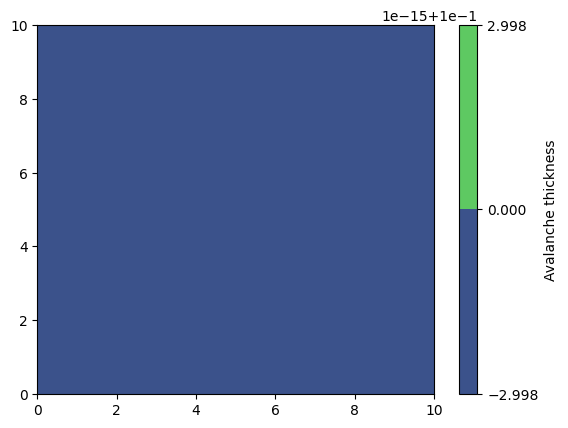

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# Define the parameters
g = 9.81  # gravity
h = 0.1  # initial thickness of the avalanche
alpha = 30  # slope angle in degrees
mu = 0.6  # friction coefficient

# Convert the slope angle to radians
alpha = np.radians(alpha)

# Define the domain
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

# Initialize the avalanche thickness and velocity
H = h * np.ones_like(X)
U = np.zeros_like(X)

# Time step and number of steps
dt = 0.01
n_steps = 100

# Create a figure for the animation
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, H)
cbar = fig.colorbar(contour, ax=ax, label='Avalanche thickness')

# Update function for the animation
def update(i):
    global H, U

    # Compute the fluxes
    Fx = H * U
    Fy = H * U**2 + 0.5 * g * H**2 * np.sin(alpha)

    # Update the avalanche thickness and velocity
    H -= dt * (np.gradient(Fx, axis=0) + np.gradient(Fy, axis=1))
    U += dt * g * H * np.sin(alpha) / (H + 1e-6)  # add a small number to avoid division by zero

    # Apply the friction law
    U *= np.exp(-mu * g * dt * np.cos(alpha) / (U + 1e-6))  # add a small number to avoid division by zero

    time.sleep(1)
    # Update the contour plot
    for collection in contour.collections:
        collection.remove()
    contour = ax.contourf(X, Y, H)
    cbar.on_mappable_changed(contour)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=n_steps)

# Display the animation
plt.show()


C:\Users\adamk\AppData\Local\Temp\ipykernel_35136\4182376235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sifted['Source'] = 'Sifted'
C:\Users\adamk\AppData\Local\Temp\ipykernel_35136\4182376235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['Source'] = 'Full'


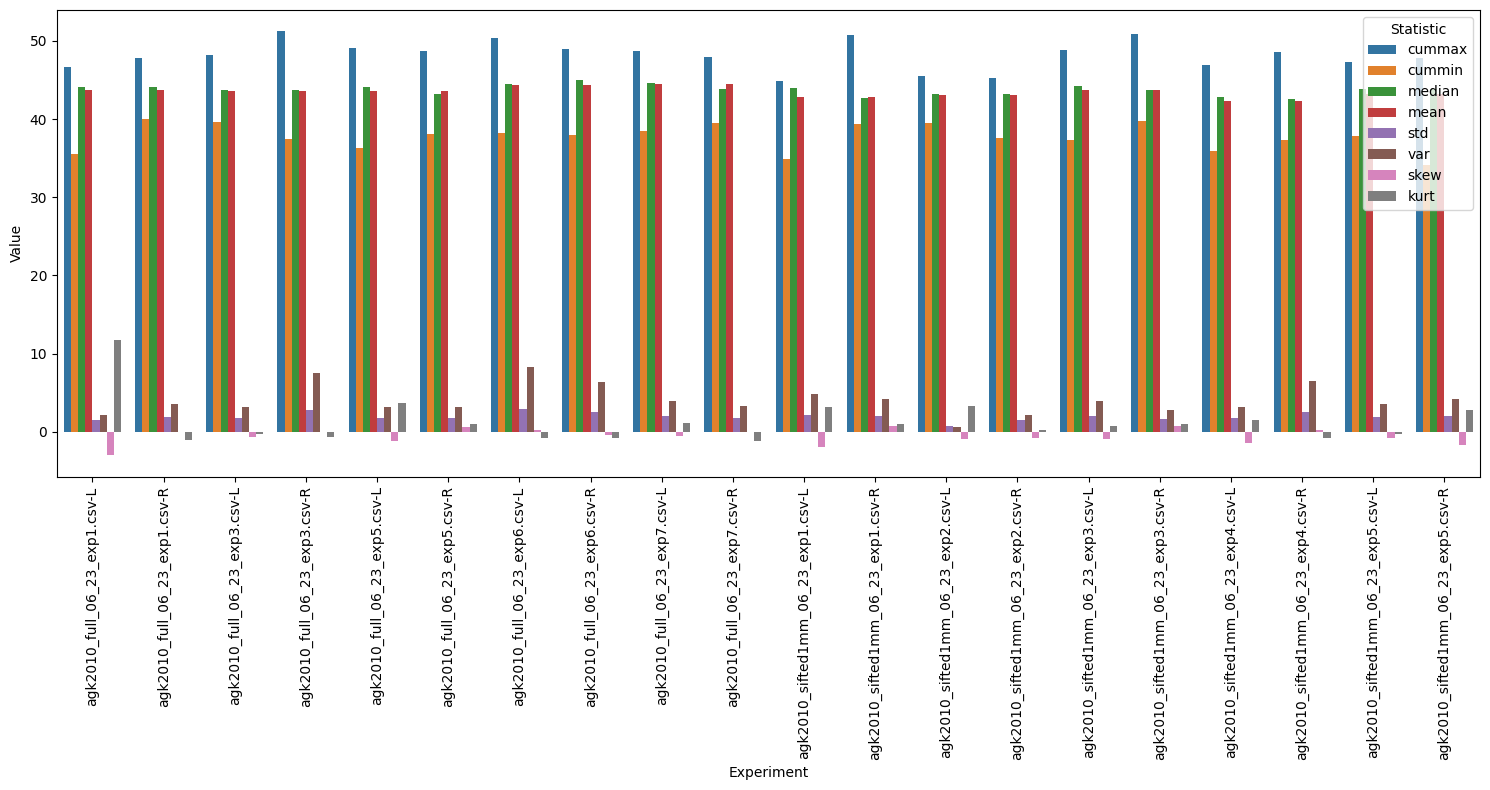

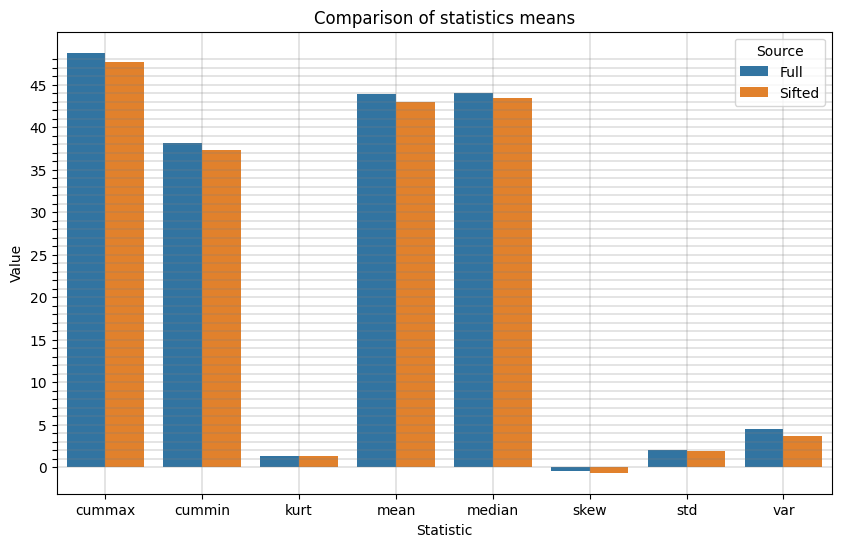

,Experiment,Statistic,Value,Source
155,agk2010_sifted1mm_06_23_exp3.csv-R,kurt,0.950283,Sifted
156,agk2010_sifted1mm_06_23_exp4.csv-L,kurt,1.543931,Sifted
157,agk2010_sifted1mm_06_23_exp4.csv-R,kurt,-0.730169,Sifted
158,agk2010_sifted1mm_06_23_exp5.csv-L,kurt,-0.243168,Sifted
159,agk2010_sifted1mm_06_23_exp5.csv-R,kurt,2.863485,Sifted


In [12]:
import seaborn as sns

# Convert the nested dictionary into a DataFrame
df = pd.DataFrame(stats)

# Unwrap single-element lists
df = df.applymap(lambda x: x[0])

# Transpose the DataFrame so that each row corresponds to a dataframe
df = df.transpose()

# Reset the DataFrame index
df_reset = df.reset_index()

# Melt the DataFrame to long format
df_melt = df_reset.melt(id_vars='index')

# Rename the columns
df_melt.columns = ['Experiment', 'Statistic', 'Value']
mask = df_melt['Experiment'].str.contains("sifted")
df_sifted = df_melt[mask]
df_full = df_melt[~mask]
df_sifted['Source'] = 'Sifted'
df_full['Source'] = 'Full'
df_comb = pd.concat([df_sifted, df_full])

# Create the barplot
plt.figure(figsize=(15,8))
sns.barplot(data=df_melt, x='Experiment', y='Value', hue='Statistic')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
mean_statistics_sifted = df_sifted.groupby('Statistic')['Value'].mean().reset_index()
mean_statistics_full = df_full.groupby('Statistic')['Value'].mean().reset_index()
mean_statistics_sifted['Source'] = 'Sifted'
mean_statistics_full['Source'] = 'Full'
combined_df = pd.concat([mean_statistics_full, mean_statistics_sifted])
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='Statistic', y='Value', hue='Source')
plt.title('Comparison of statistics means')
plt.grid(True, linewidth=0.3, color='gray', linestyle='-')
yticks = np.arange(int(min(combined_df['Value'])), int(max(combined_df['Value']))+1, 1)
plt.yticks(yticks)

# create labels for every fifth ytick, leave others blank
yticklabels = [str(y) if y % 5 == 0 else '' for y in yticks]
plt.gca().set_yticklabels(yticklabels)
plt.show()

df_sifted.tail()


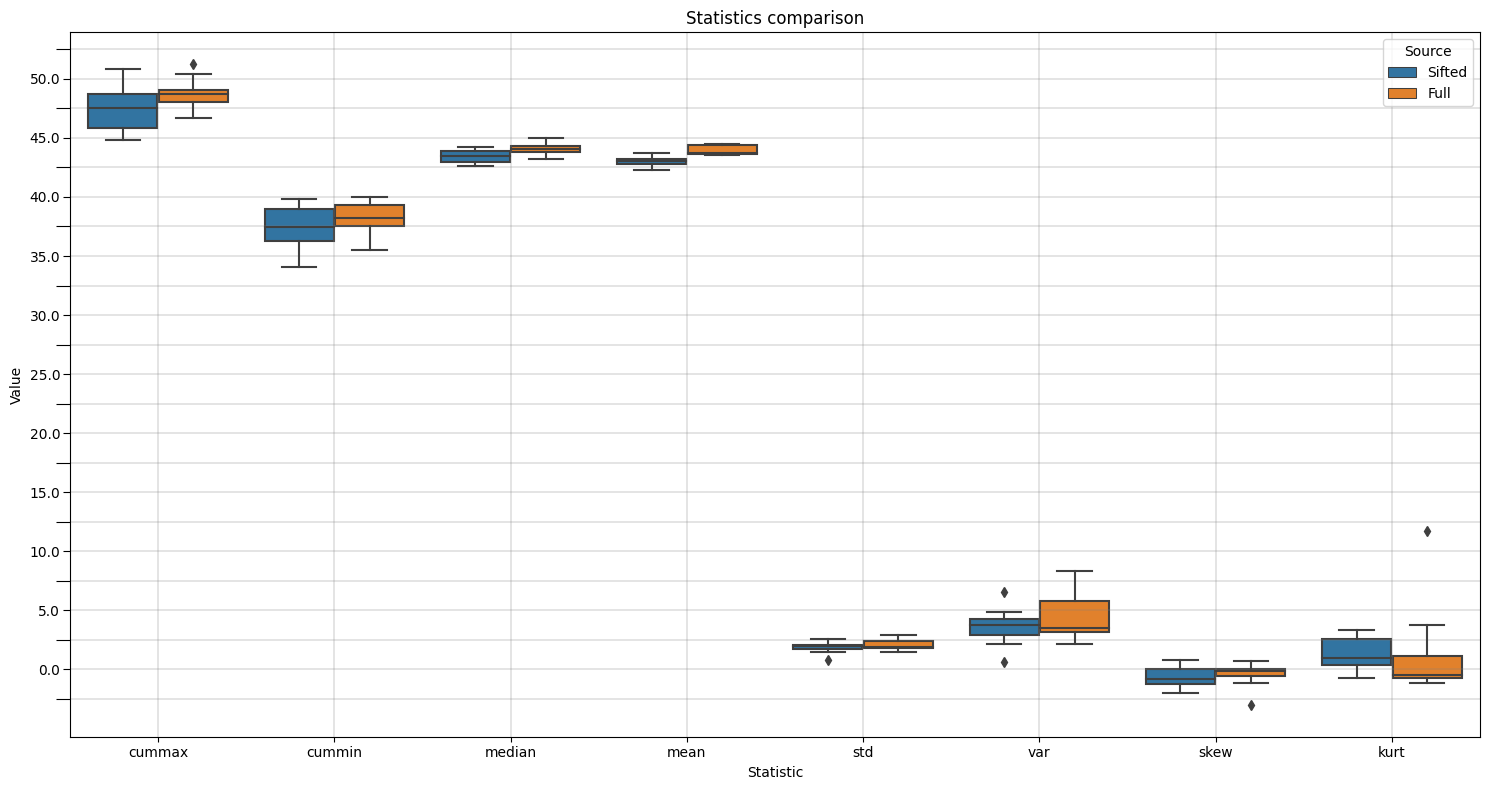

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Statistic', y='Value', hue='Source', data=df_comb)
yticks = np.arange(-2.5, 55, 2.5)
plt.yticks(yticks)
# create labels for every fifth ytick, leave others blank
yticklabels = [str(y) if y % 5 == 0 else '' for y in yticks]
plt.gca().set_yticklabels(yticklabels)

# Set tick width depending on if the tick is even or odd
for i, tick in enumerate(plt.gca().yaxis.get_major_ticks()):
    if i % 2 == 0:  # Even ticks
        tick.tick1line.set_markersize(10)  # Make even ticks larger
    else:  # Odd ticks
        tick.tick1line.set_markersize(5)  # Make odd ticks smaller
plt.title("Statistics comparison")
plt.grid(True, linewidth=0.3, color='gray', linestyle='-')
plt.tight_layout()

plt.show()

In [14]:
# WAVELET

# from statsmodels.graphics.tsaplots import plot_acf
# # Assuming df is your DataFrame and 'angle' is your column of interest
# # angle_values = new_df['angle'].values
# angle_values=new_df[new_df['Experiment'].str.contains("agk2010_sifted1mm_06_23_exp5.csv")]['Right Angle Derivative2']
# import pywt
# import matplotlib.pyplot as plt

# # Assume df is your DataFrame and 'angle' is the column you want to transform
# # values = df['angle'].values

# # define wavelet function
# wavelet = 'morl'  # Morlet wavelet

# # define scale (you might need to adjust this according to your data)
# scales = np.arange(1, len(angle_values) + 1)

# # perform CWT
# coefficients, frequencies = pywt.cwt(angle_values, scales, wavelet)

# # plot the wavelet transform coefficients
# plt.matshow(coefficients, aspect='auto')  
# plt.show()


In [15]:
# import scipy.signal

# values=new_df[new_df['Experiment'].str.contains("agk2010_sifted1mm_06_23_exp5.csv")]['Right Angle Derivative2']

# # Assume df is your DataFrame and 'angle' is the column you want to analyze
# # values = df['angle'].values
# plt.figure(figsize=(10, 6))


# # Define your sampling rate (e.g., 1 sample per second)
# fs = 60.0

# # Calculate the frequency and power spectral density
# frequency, power = scipy.signal.periodogram(values, fs=fs)

# # Plot the periodogram
# plt.semilogy(frequency, power)
# plt.title('Periodogram')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Power spectral density [V**2/Hz]')
# plt.grid()
# plt.show()


In [16]:
# sns.pairplot(df_filtered, hue='Experiment')
new_df.reset_index(inplace=True)

In [17]:
print(new_df[new_df.duplicated(['Time', 'Experiment'])])
df_by_experiment = new_df.groupby('Experiment')
print(type(df_by_experiment))
# df_by_experiment["Filtered Left"].describe()

Empty DataFrame
Columns: [index, Left Angle, Right Angle, Time, Experiment, Mean, Filtered Mean, Filtered Left, Filtered Right, Right Angle Derivative, Left Angle Derivative, Right Angle Derivative2, Left Angle Derivative2, R_Der, Column_Integral, Tilt, below_threshold, below_threshold_diff]
Index: []
<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


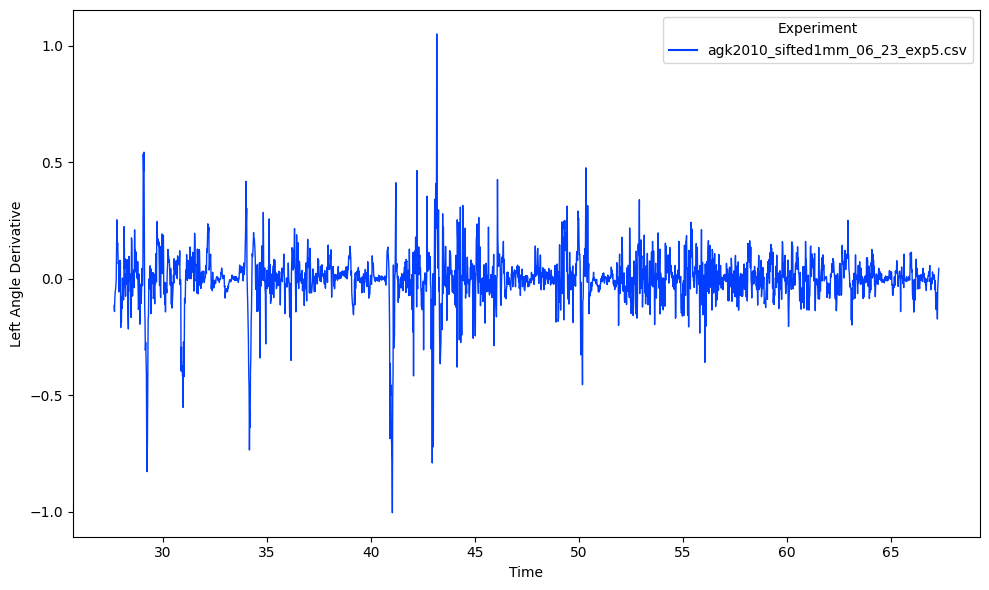

In [18]:
# df_selected = df_by_experiment.to_dataframe.reset_index()
df_melted = pd.melt(new_df, id_vars=['Experiment'], 
                    value_vars=['Time','Filtered Left', 'Filtered Right', 'Right Angle Derivative'])
# ax1 = sns.lineplot(data=df_melted, x="Time", y='value', 
#                    hue='Experiment', palette='bright', linewidth='1')
plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains("agk2010_sifted1mm_06_23_exp5.csv")], x="Time", y='Left Angle Derivative', 
                   hue='Experiment', palette='bright', linewidth='1')
plt.tight_layout()
plt.show()

In [19]:
df_by_experiment = new_df.groupby('Experiment')
print(type(df_by_experiment))
# df_by_experiment["Filtered Left"].describe()
result = df_by_experiment.describe()

# df_med_by_experiment["Tilt"]= df_by_experiment["Tilt"].median()
# df_med_by_experiment.head()
# result["Filtered Right"].agg(['min', 'max', 'std'])
# Flatten the column hierarchy
result.columns = ['_'.join(col).strip() for col in result.columns.values]
# result.drop(level = 1, index="Left Angle", axis=columns)
# Now, you can select the columns you need
final_df = result[[col for col in result.columns if 'min' in col or 'max' in col or 'std' in col or 'mean' in col]]
final_df.reset_index()


<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


,Experiment,index_mean,index_std,index_min,index_max,Left Angle_mean,Left Angle_std,Left Angle_min,Left Angle_max,Right Angle_mean,...,Column_Integral_min,Column_Integral_max,Tilt_mean,Tilt_std,Tilt_min,Tilt_max,below_threshold_diff_mean,below_threshold_diff_std,below_threshold_diff_min,below_threshold_diff_max
0,agk2010_full_06_23_exp1.csv,1842.5,299.211742,1325.0,2360.0,43.015046,1.461268,33.218706,46.864413,44.397920,...,0.000582,0.187836,-1.408531,2.113138,-6.872107,2.606240,0.000965,0.031068,0.0,1.0
1,agk2010_full_06_23_exp3.csv,1828.0,608.382829,775.0,2881.0,45.674474,1.812962,41.451091,51.831256,41.407229,...,0.000281,0.101267,4.257927,2.314518,-3.104664,10.679578,0.000475,0.021786,0.0,1.0
2,agk2010_full_06_23_exp5.csv,1830.5,774.371035,490.0,3171.0,43.460630,1.827531,35.793205,49.755249,43.803074,...,0.000374,0.128990,-0.351061,1.959997,-7.331185,4.841946,0.000373,0.019309,0.0,1.0
3,agk2010_full_06_23_exp6.csv,2341.0,827.775936,908.0,3774.0,45.073403,2.936080,33.702828,52.125016,43.687463,...,0.000540,0.161429,1.386644,2.836232,-7.133019,11.176380,0.000000,0.026417,-1.0,1.0
4,agk2010_full_06_23_exp7.csv,2916.5,557.287329,1952.0,3881.0,44.303265,2.007417,38.187640,49.991220,44.678039,...,0.000577,0.138317,-0.369155,2.391531,-4.110813,5.317002,0.000518,0.022763,0.0,1.0
5,agk2010_sifted1mm_06_23_exp1.csv,3346.0,531.595241,2426.0,4266.0,43.545873,2.219879,34.698260,46.653141,42.114570,...,0.000331,0.139160,1.422743,3.563070,-8.008196,6.402372,0.000543,0.023306,0.0,1.0
6,agk2010_sifted1mm_06_23_exp2.csv,2442.5,418.723258,1718.0,3167.0,44.293408,0.799396,40.377377,48.207298,41.798227,...,0.000227,0.159568,2.501768,1.250385,0.625256,6.840026,0.000690,0.026261,0.0,1.0
7,agk2010_sifted1mm_06_23_exp3.csv,3375.5,1202.764940,1293.0,5458.0,43.259232,2.027635,34.692224,50.254386,44.259463,...,0.000420,0.253216,-1.000916,2.165626,-9.193271,3.723423,0.000240,0.015493,0.0,1.0
8,agk2010_sifted1mm_06_23_exp4.csv,3133.5,530.151865,2216.0,4051.0,42.338663,1.765489,35.819136,47.529278,42.243870,...,0.000351,0.138468,0.072552,3.535249,-6.941189,6.090612,0.000545,0.023338,0.0,1.0
9,agk2010_sifted1mm_06_23_exp5.csv,2848.5,686.613792,1660.0,4037.0,42.347810,1.984525,31.528988,50.083727,44.127177,...,0.000687,0.146098,-1.778576,2.596769,-7.820327,7.754709,0.000421,0.020507,0.0,1.0


In [20]:
df_imp_L = final_df[['Left Angle_mean', 'Left Angle_std', 'Left Angle_min', 'Left Angle_max']]
df_imp_R = final_df[['Right Angle_mean', 'Right Angle_std', 'Right Angle_min', 'Right Angle_max']]
df_join = pd.concat([df_imp_L.rename(columns={'Experiment': 'Experiment','Left Angle_mean': 'Angle_mean','Left Angle_std': "Angle_std", 'Left Angle_min': 'Angle_min', 'Left Angle_max': 'Angle_max'}), df_imp_R.rename(columns={'Experiment': 'Experiment', 'Right Angle_mean': 'Angle_mean',"Right Angle_std": "Angle_std", 'Right Angle_min': 'Angle_min', 'Right Angle_max': 'Angle_max'})], ignore_index=False)
# df_join = df_join.reset_index()


In [21]:
df_reset = df_join.reset_index()
df_reset.columns

Index(['Experiment', 'Angle_mean', 'Angle_std', 'Angle_min', 'Angle_max'], dtype='object')

In [22]:
df_reset["sifted"] = True
df_reset.loc[df_reset['Experiment'].str.contains("full"), "sifted"] = False
df_reset

,Experiment,Angle_mean,Angle_std,Angle_min,Angle_max,sifted
0,agk2010_full_06_23_exp1.csv,43.015046,1.461268,33.218706,46.864413,False
1,agk2010_full_06_23_exp3.csv,45.674474,1.812962,41.451091,51.831256,False
2,agk2010_full_06_23_exp5.csv,43.460630,1.827531,35.793205,49.755249,False
3,agk2010_full_06_23_exp6.csv,45.073403,2.936080,33.702828,52.125016,False
4,agk2010_full_06_23_exp7.csv,44.303265,2.007417,38.187640,49.991220,False
5,agk2010_sifted1mm_06_23_exp1.csv,43.545873,2.219879,34.698260,46.653141,True
6,agk2010_sifted1mm_06_23_exp2.csv,44.293408,0.799396,40.377377,48.207298,True
7,agk2010_sifted1mm_06_23_exp3.csv,43.259232,2.027635,34.692224,50.254386,True
8,agk2010_sifted1mm_06_23_exp4.csv,42.338663,1.765489,35.819136,47.529278,True
9,agk2010_sifted1mm_06_23_exp5.csv,42.347810,1.984525,31.528988,50.083727,True


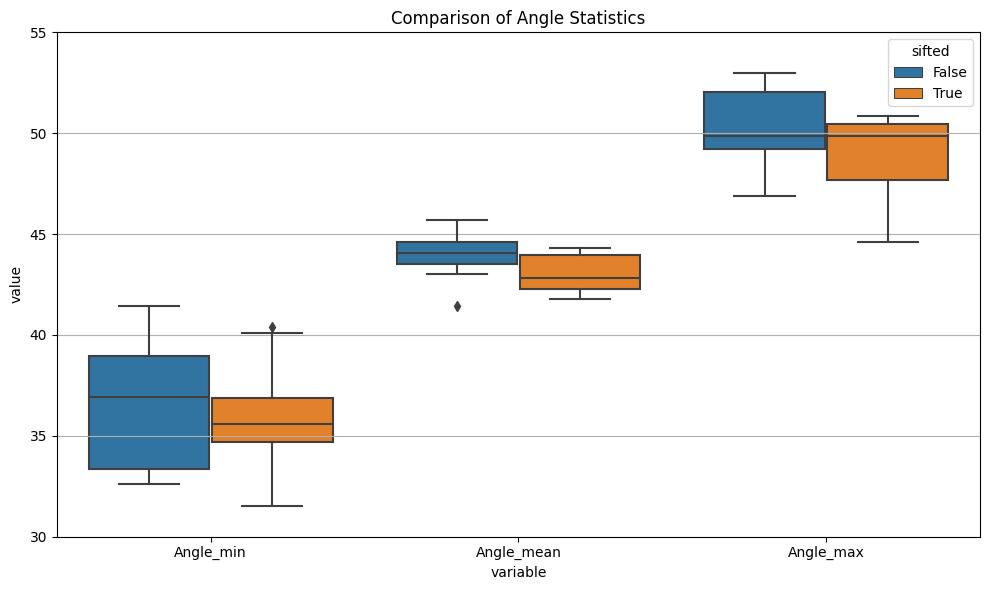

In [23]:
df_melted = pd.melt(df_reset, id_vars=['Experiment', 'sifted'], 
                    value_vars=['Angle_min', 'Angle_mean','Angle_max'])

plt.figure(figsize=(10, 6))

# Create the violinplot
sns.boxplot(x='variable', y='value', hue='sifted', data=df_melted)
plt.grid(axis='y')
plt.ylim(30, 55)
plt.title('Comparison of Angle Statistics')
plt.tight_layout()
plt.show()

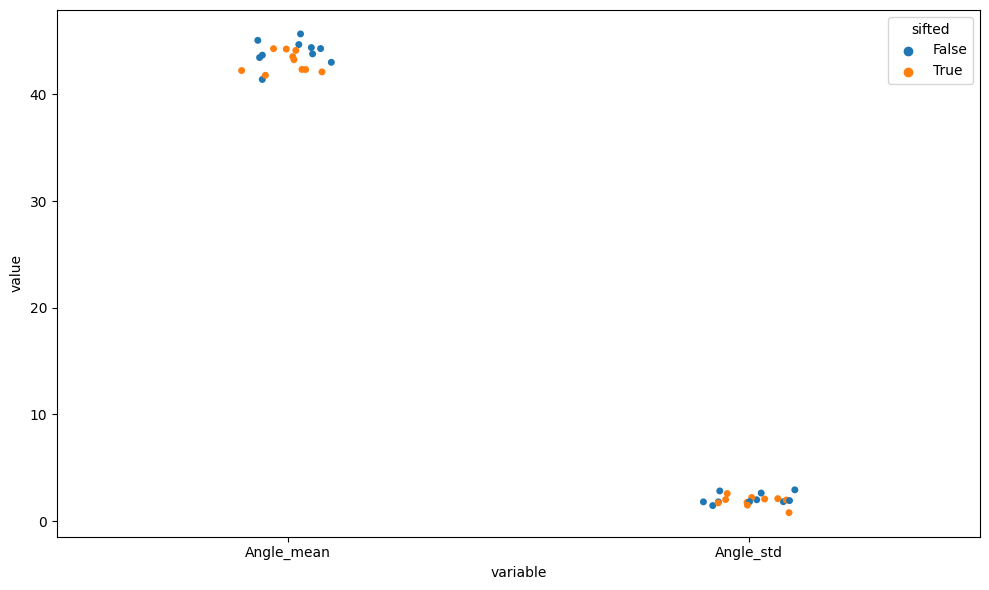

In [24]:
df_melted = pd.melt(df_reset, id_vars=['Experiment', 'sifted'], 
                    value_vars=['Angle_mean', 'Angle_std'])

# Create a scatterplot
plt.figure(figsize=(10, 6))
sns.stripplot(x='variable', y='value', data=df_melted, hue='sifted', jitter=True)

# Improve layout
plt.tight_layout()
plt.show()

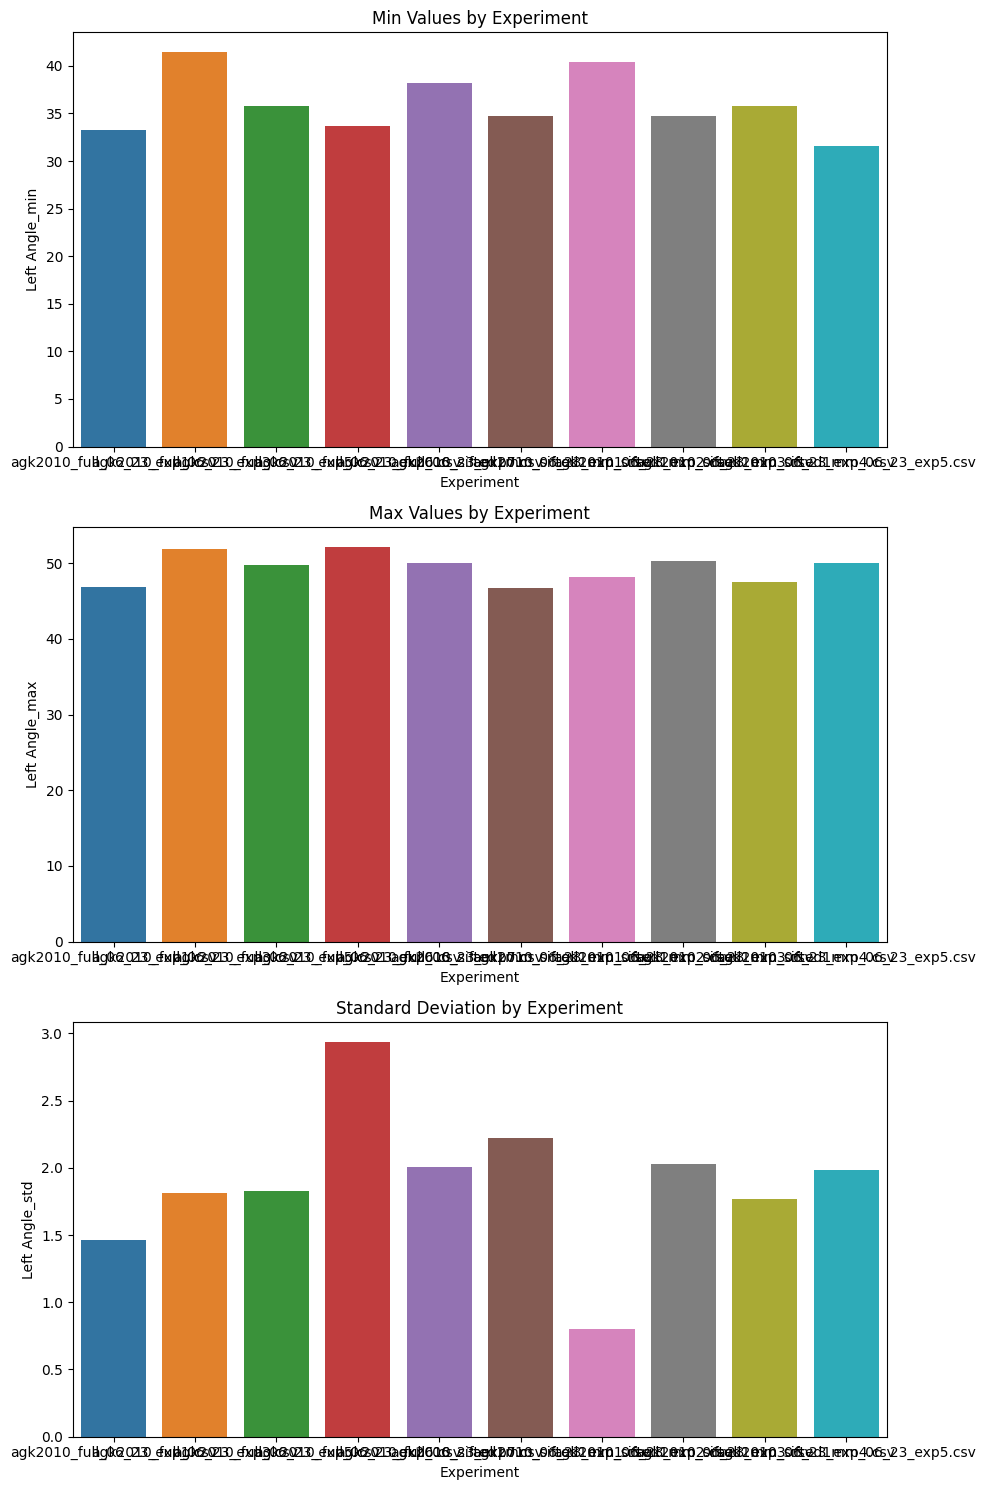

In [25]:
# Create a new figure with 3 subplots, one for each statistic
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot min values
sns.barplot(data=final_df, x=final_df.index, y="Left Angle_min", ax=ax[0])
ax[0].set_title('Min Values by Experiment')

# Plot max values
sns.barplot(data=final_df, x=final_df.index, y="Left Angle_max", ax=ax[1])
ax[1].set_title('Max Values by Experiment')

# Plot standard deviation values
sns.barplot(data=final_df, x=final_df.index, y="Left Angle_std", ax=ax[2])
ax[2].set_title('Standard Deviation by Experiment')

# Improve layout
plt.tight_layout()
plt.show()

In [26]:
%matplotlib qt
plt.style.use("dark_background")

keyword1 = "agk2010_full_06_23_exp3.csv"
keyword2 = 'agk2010_sifted1mm_06_23_exp3.csv'

a4_dims = (11.7, 8.27)
# ax = plt.subplots(figsize=a4_dims, dpi=500)
fig, ax = plt.subplots()
# ax1 = sns.lineplot(data=df_filtered[df_filtered['Experiment'].str.contains(keyword)], x="Time", y='Left Angle', 
#                    hue='Experiment', palette='viridis', linewidth='0.5')
# ax2 = sns.lineplot(data=df_filtered[df_filtered['Experiment'].str.contains(keyword)], x="Time", y='Right Angle', 
#                    hue='Experiment', palette='YlOrBr', linewidth='0.5')


ax1 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Left', 
                   hue='Experiment', palette='bright', linewidth='1')

# ax2 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Right', 
#                    hue='Experiment', palette='dark', linewidth='1')



# ax1 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Left', 
#                    hue='Experiment', palette='bright', linewidth='1')

# ax2 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Right', 
#                    hue='Experiment', palette='dark', linewidth='1', dashes=True)

# ax3 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='R_Der', 
#                    hue='Experiment', palette='tab10', linewidth='1')

# ax4 = sns.lineplot(data=new_df[new_df['Experiment'].str.contains(keyword2)], x="Time", y='Right Angle Derivative2', 
#                    hue='Experiment', palette='tab10', linewidth='1')

# ax2 = sns.lineplot(data=df_filtered[df_filtered['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Mean', 
#                    hue='Experiment', palette=['blue'], linewidth='1')

ax3 = sns.lineplot(data=df_filtered[df_filtered['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Left', hue='Experiment', 
                   palette=['red'], linewidth='0.5')

# ax3 = sns.lineplot(data=df_filtered[df_filtered['Experiment'].str.contains(keyword2)], x="Time", y='Filtered Right', hue='Experiment',
#                    palette=['green'], linewidth='0.5')


# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.ylim(-5, 55)
# plt.xlim(0, 150)
plt.ion()
plt.title("Sifted distribution experiments")
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
new_df.describe()

,index,Left Angle,Right Angle,Time,Mean,Filtered Mean,Filtered Left,Filtered Right,Right Angle Derivative,Left Angle Derivative,Right Angle Derivative2,Left Angle Derivative2,R_Der,Column_Integral,Tilt,below_threshold_diff
count,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,2.229300e+04,2.229300e+04,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000,22293.000000
mean,2660.077244,43.741986,43.386764,44.334621,43.564375,43.562009,43.562009,43.562009,-6.514774e-05,8.716315e-04,0.000022,0.000011,0.040392,0.013032,0.350535,0.000404
std,981.097701,2.289036,2.406089,16.351628,1.745415,1.713405,2.091701,2.176094,1.064889e-01,9.419614e-02,0.054091,0.063194,0.044503,0.017079,3.087784,0.022210
min,490.000000,31.528988,32.601481,8.166667,33.152155,38.101850,34.955978,34.081233,-1.817680e+00,-1.115858e+00,-1.324388,-0.923229,0.001121,0.000227,-9.193271,-1.000000
25%,1961.000000,42.604994,42.037024,32.683333,42.459463,42.478821,42.539782,42.276701,-1.540846e-02,-1.799106e-02,-0.014475,-0.017800,0.012728,0.003280,-1.960197,0.000000
50%,2616.000000,43.792135,43.501522,43.600000,43.592165,43.584399,43.731928,43.616688,7.105427e-15,7.105427e-15,0.000000,0.000000,0.024670,0.007349,0.447451,0.000000
75%,3316.000000,44.833604,44.891176,55.266667,44.544716,44.516132,44.703821,44.830572,2.267980e-02,2.492330e-02,0.014627,0.018253,0.052465,0.016099,2.635099,0.000000
max,5458.000000,52.125016,61.788296,90.966667,55.898069,49.382712,50.385631,51.232326,1.675355e+00,1.051643e+00,1.319906,1.092708,0.438507,0.253216,11.176380,1.000000


In [28]:

# graphs = {}

# legend = plt.legend(loc='upper right')
# print(legend.get_lines())
# line_legend = legend.get_lines()
# for line in enumerate(line_legend):
#     line.set_picker(True)
#     line.set_pickradius(10)
#     graphs[i] = line

# # graphs[line_legend] = ax1
# # graphs[dot_legend] = ax2



# def on_pick(event):
#     legend = event.artist
#     isVisible = legend.get_visible()

#     graphs[legend].set_visible(not isVisible)
#     legend.set_visible(not isVisible)

#     fig.canvas.draw()

# plt.connect('pick_event', on_pick)
# plt.show()

In [29]:
# %matplotlib notebook
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib

# def pandas_plot(ax, df, style_cycle, **kwargs):
#     """
#     Plot a pandas DataFrame

#     Parameters
#     ----------
#     ax : matplotlib.axes.Axes
#         The axes to plot to

#     df : pd.DataFrame
#         The data to plot

#     style_cycle : Cycler
#         Something that when iterated over yields style dict

#     Returns
#     -------
#     ret : dict
#         Dictionary of line2d artists added 
#     """
#     ret = {}
#     x = df.index
#     for n, sty in zip(df.columns, style_cycle):
#         sty.update(kwargs)
#         ln, = ax.plot(x, df[n], label=n, **sty)
#         ret[n] = ln
#     ax.legend()
#     return ret

In [30]:
# import pstats
# from pstats import SortKey

# with open("output_time.txt", "w") as f:
#     p = pstats.Stats("C:/Users/adamk/Projects/slope-finder/profiling_output.dat", stream=f)
#     p.sort_stats("time").print_stats()